In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import re
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import random

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#cd 'drive/MyDrive/jpm'

/content/drive/MyDrive/jpm


### Data Preprocessing and Exploratory Data Analysis

In [4]:
enron = pd.read_csv('enron_test.csv')

In [5]:
#first search for any missing value in the dataset
enron.isna().any()

Date        False
From        False
To           True
Subject      True
content     False
new_date    False
dtype: bool

In [6]:
#Find how many emails don't have receiver(s)
print("Number of samples whose receiver is NaN:",len(enron[enron['To'].isna()]))

Number of samples whose receiver is NaN: 5


In [7]:
#Find how many emails don't have subject(s)
print("Number of samples whose Subject is NaN:",len(enron[enron['Subject'].isna()]))

Number of samples whose Subject is NaN: 302


We know from the above output that there are 5 emails with no receiver and 302 emails with no subjects.

Now we clean the "From" and "To" columns of the dataset, we store the receivers of each email in a list because there might be multiple receivers for one email.

In [8]:
#extract senders' emails 
for i in range(len(enron['From'])):
  email = enron['From'][i]
  enron.loc[i,'From'] = re.search("(?:frozenset\(\{)(.+)(?:\}\))",email).group(1)

In [9]:
#extract recipients' emails and store in a list
for i in range(len(enron['To'])):
  email = enron['To'][i]
  try:
    recipients = re.search("(?:frozenset\(\{)(.+)(?:\}\))",email).group(1)
    enron.loc[i,'To'] = recipients.split(",")
  except TypeError:
    #if not recipient, return empty list
    enron.loc[i,'To'] = []


In [10]:
#change date to Datetime format, use "new_date" for further use cases
enron['new_date'] = pd.to_datetime(enron['new_date'])

### Cleaning text

In [11]:
#replace special charactors, punctuation, and digits with space then remove unnecessary spaces
enron["content"]=enron['content'].apply(lambda x: str(x).replace("\n"," "))
enron["content"]=enron['content'].apply(lambda x: str(x).replace("-"," "))
enron["content"]=enron['content'].apply(lambda x: str(x).replace("_"," "))
enron["content"]=enron['content'].apply(lambda x: str(x).replace("/"," "))
enron["content"]=enron['content'].apply(lambda x: str(x).replace("@"," "))
enron["content"]=enron['content'].apply(lambda x: str(x).replace("\t"," "))
enron["content"]=enron['content'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
enron["content"]=enron['content'].apply(lambda x: re.sub(r'[0-9]*', '', str(x)))
enron["content"]=enron['content'].apply(lambda x: re.sub(r' +', ' ', str(x)))


In [12]:
def match_sender_receiver(df):
  """
  This function return a dictionary where the keys are email senders and the values are 
  dictionaries with keys=email receivers and values = list of emails of the same sender and receiver
  """
  pair_content = dict()
  for sender in df['From'].unique():
    
    to_df = df.loc[df['From']==sender,['To','content']].reset_index(drop=True)
    sent_email = dict()
    for r in range(len(to_df)):
      receivers = to_df['To'][r]
      for receiver in receivers:
        receiver = receiver.replace(" ","")
        try:
          sent_email[receiver].append(re.sub(r'[0-9]+', '', to_df['content'][r]))
        except KeyError:
          sent_email[receiver] = [to_df['content'][r]]
    pair_content[sender] = {k: v for k, v in sorted(sent_email.items(), key=lambda k: len(k[1]), reverse=True)}
  return pair_content



In [13]:
emails = match_sender_receiver(enron)

## EDA 

In [14]:
enron['From'].value_counts()

'phillip.allen@enron.com'                    946
'critical.notice@enron.com'                    5
'ina.rangel@enron.com'                         4
'aod@newsdata.com'                             2
'jsmith@austintx.com'                          2
'announce@inbox.nytimes.com'                   2
'ei_editor@ftenergy.com'                       2
'messenger@ecm.bloomberg.com'                  2
'sarah.novosel@enron.com'                      2
'webmaster@earnings.com'                       2
'richard.shapiro@enron.com'                    1
'rebecca.cantrell@enron.com'                   1
'matt@fastpacket.net'                          1
'perfmgmt@enron.com'                           1
'tiffany.miller@enron.com'                     1
'market-reply@listserv.dowjones.com'           1
'christi.nicolay@enron.com'                    1
'gthorse@keyad.com'                            1
'subscriptions@intelligencepress.com'          1
'yild@zdemail.zdlists.com'                     1
'jfreeman@ssm.net'  

We need to notice that this is a truncated dataset. If we look at the number of senders, we can observe that most emails in this truncated data set were sent by 'phillip.allen@enron.com'. We might lose some general information on email senders from this truncated dataset, but we can conduct data visualization on emails sent by this particular email address.

In [15]:
 enron['year']=pd.DatetimeIndex(enron['new_date']).year
 enron['month']=pd.DatetimeIndex(enron['new_date']).month

We will visualize the change of number of emails sent by phillip.allen@enron.com in year 2000.

    month  Subject
0       1       20
1       2       32
2       3       46
3       4       22
4       5       18
5       6       26
6       7       53
7       8       64
8       9       48
9      10       31
10     11       19
11     12       22


Text(0.5, 1.0, 'Number of emails sent by phillip.allen@enron.com in 2020 by month')

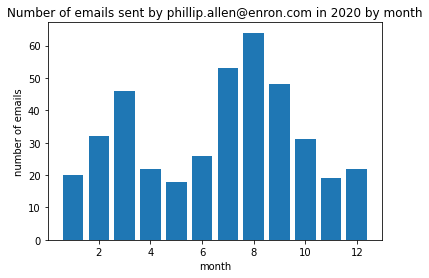

In [16]:
phillip_sent = enron.loc[enron['From']=="'phillip.allen@enron.com'",:]
phillip_sent = phillip_sent.loc[enron['year']==2000,:]
by_month=phillip_sent.groupby(['month']).Subject.count().reset_index()
print(by_month)
plt.bar(by_month['month'],by_month['Subject'])
plt.xlabel("month")
plt.ylabel('number of emails')
plt.title("Number of emails sent by phillip.allen@enron.com in 2020 by month")

There's not a clear pattern of number of emails sent by phillip.allen@enron.com. From the plot, we can notice that this email address sent most email in August and set least email in May.

we can also visulaize the commonly used topic/word in the email content by plotting the wordcloud image. 

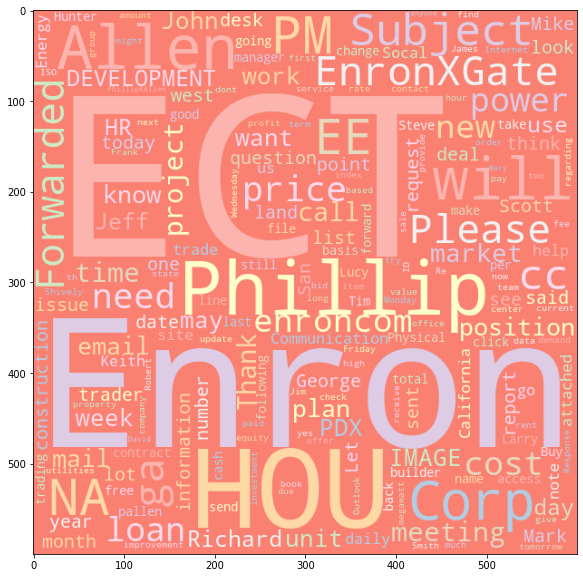

In [17]:

email_content = list(enron['content'])

# Generate word cloud after removing stopping words
wc = WordCloud(width= 600, height = 600, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(" ".join(email_content))
# Plot
plt.figure(figsize = (10,10))
plt.imshow(wc)

After dropping stopping words, this wordcloud still makes sense since we already know most emails in this datset were sent by phillip.Moreover, all the emails were collected from Enron, so "Enron" occurs frequently. After glancing at the email content, we know that "ECT" and "Hou" come from the forward email content "Allen/HOU/ECT".

Now, since the above wordcloud is not informative, we draw the wordcloud again by manually removing the 20 most frequent words after removing the stopping words.

In [18]:
from collections import Counter


email_content = list(enron['content'])
# split() returns list of all the words in the string
split_it = " ".join(email_content).split()



remove  = [word for word in split_it if word.lower() not in STOPWORDS]

Count = Counter(remove)
  
most_occur = Count.most_common(20)

most_occur = [x[0].lower() for x in most_occur]
remove  = [word for word in remove if word.lower() not in most_occur]

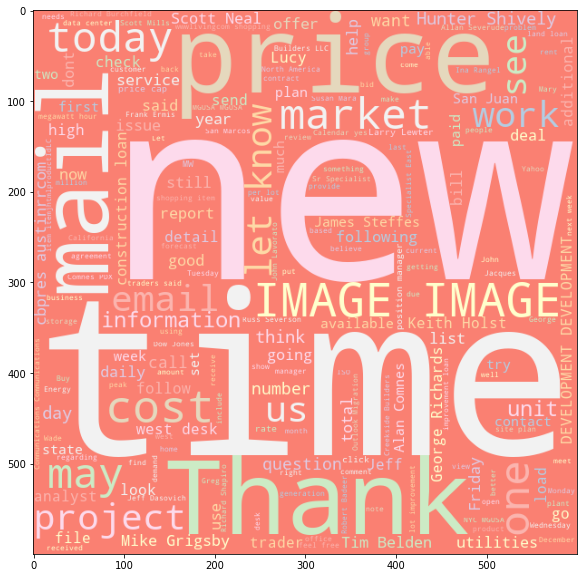

In [19]:
# Generate word cloud after removing stopping words
wc = WordCloud(width= 600, height = 600, random_state=1, background_color='salmon', colormap='Pastel1', collocations=True).generate(" ".join(remove))
# Plot
plt.figure(figsize = (10,10))
plt.imshow(wc)

We can also explore the network of phillip.allen@enron.com by looking at who received the most emails from this email address. 

In [20]:
#look at network of phillip to whom he sent more than 10 email (in the dataset)

def create_frequent_relation_graph(email_dict,remove_list, sender ="'phillip.allen@enron.com'"):
  """
  This function create a graph where nodes are sender:phillip.allen@enron.com and receivers:who receives more than 10 emails from phillip.allen@enron.com.
  I also add edge attribute, number:number of emails received,  frequent_word: 10 most frequent words in all the emails they receive
  """
  G = nx.DiGraph()
  G.add_node(sender)

  for receiver,content in email_dict[sender].items():
    if len(content)>=10:
      G.add_node(receiver)
      G.add_edge(sender,receiver)
      G.edges[sender,receiver]['number'] = len(content)
      #remove stopping words and common name
      words = " ".join(content).split()
      words  = [word.lower() for word in words if word.lower() not in remove_list]
      Count = Counter(words)
      frequent = Count.most_common(10) 
      G.edges[sender,receiver]['frequent_words'] = [x[0] for x in frequent]
  return G

In [22]:
REMOVE_LIST = list(STOPWORDS)+most_occur
G = create_frequent_relation_graph(emails,REMOVE_LIST)

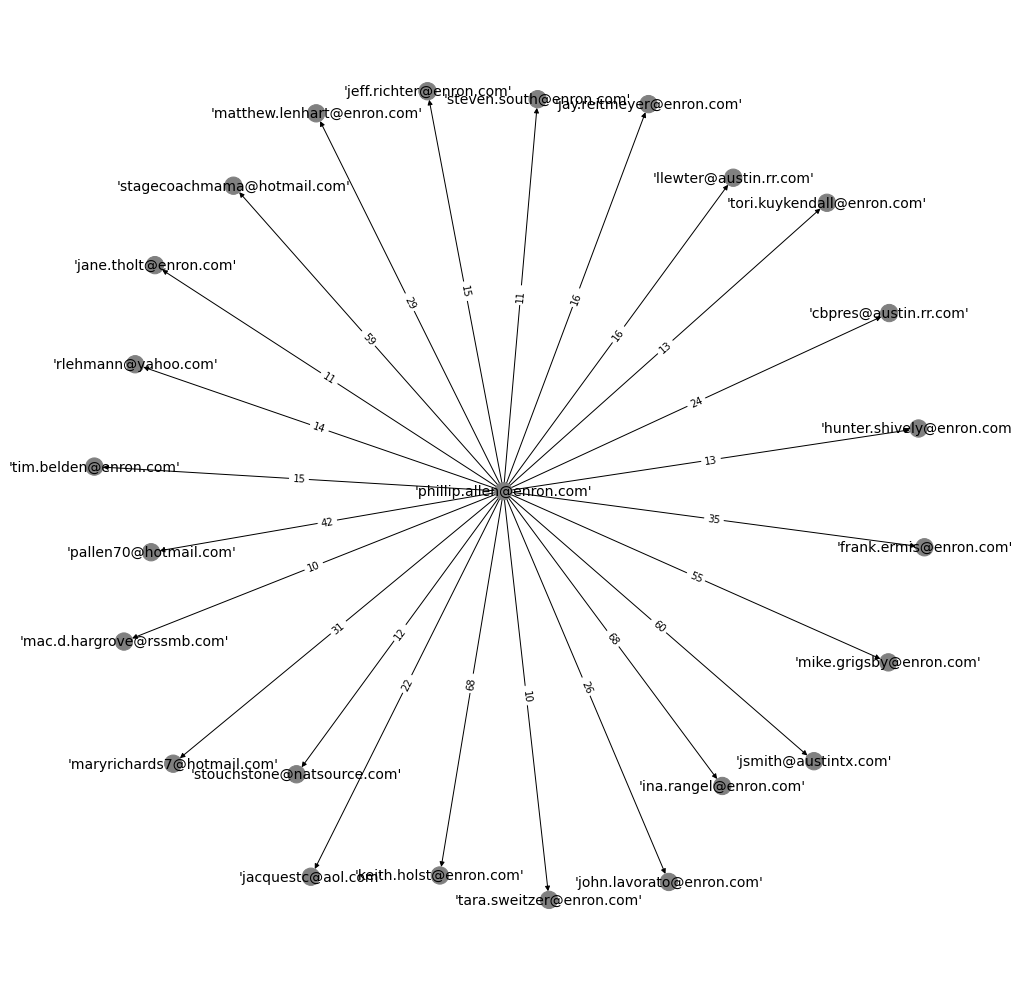

In [23]:
plt.figure(figsize = (18,18))
edge_labels=dict([((u,v,),d['number']) for u,v,d in G.edges(data=True)])
#edge_width=[d['number']/10 for u,v,d in G.edges(data=True)]
pos=nx.spring_layout(G)
node_color = ['white' if node =="phillip.allen" else 'grey' for node in G.nodes()]
node_labels = {node:node for node in G.nodes()} 
nx.draw_networkx_labels(G, pos, labels=node_labels,font_size =14)

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos,node_color = node_color, edge_cmap=plt.cm.Reds)
plt.show()

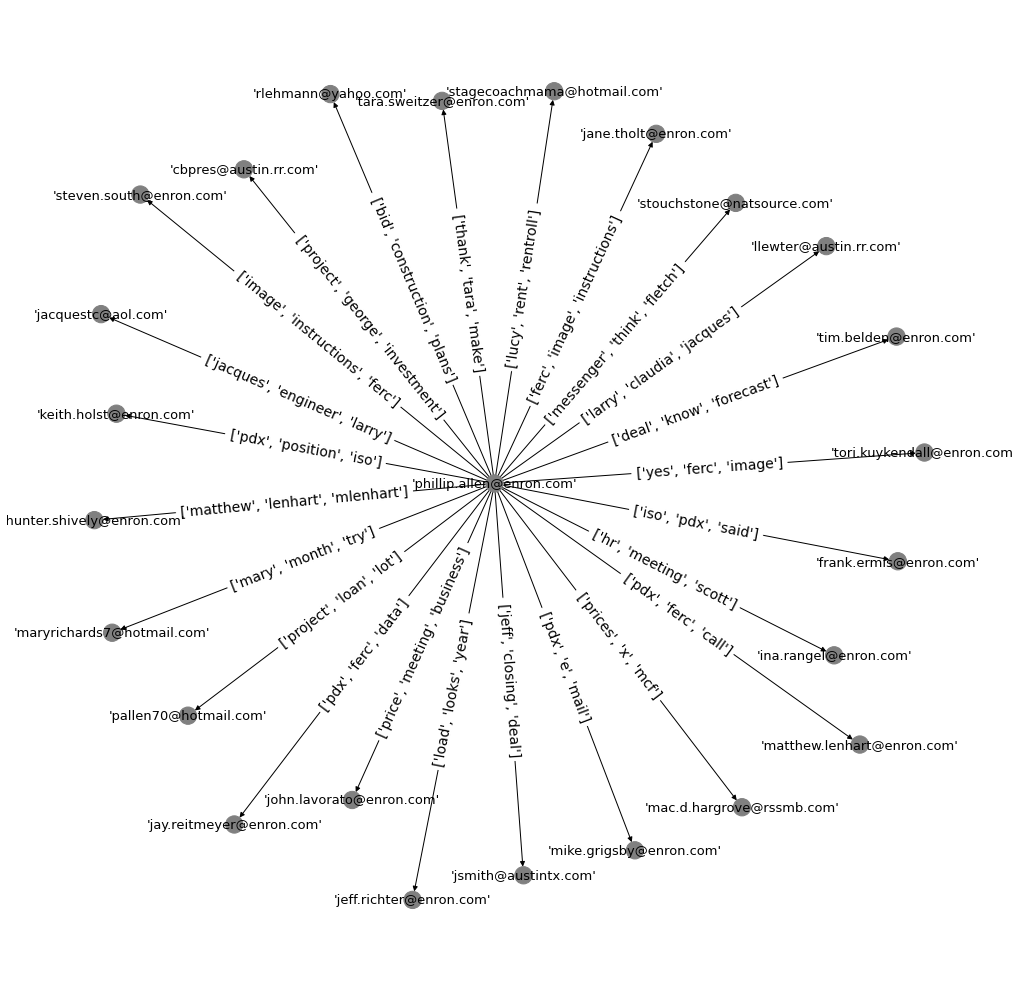

In [24]:
plt.figure(figsize = (18,18))
edge_labels=dict([((u,v,),d['frequent_words'][:3]) for u,v,d in G.edges(data=True)])
#edge_width=[d['number']/10 for u,v,d in G.edges(data=True)]
pos=nx.spring_layout(G)
node_color = ['white' if node =="phillip.allen" else 'grey' for node in G.nodes()]
node_labels = {node:node for node in G.nodes()} 
nx.draw_networkx_labels(G, pos, labels=node_labels,font_size =13)

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_size =14)
nx.draw(G,pos,node_color = node_color, edge_cmap=plt.cm.Reds)
plt.show()

From the above two graphs, we can observe that keith.holst@enron.com receive most(68) emails from phillip.allen@enron.com, and the top 3 words appeared in all the emails received is "power","pdx","position".

### Use Cases for the Data Set

Since we only have the subject and the content of the emails, and it's unreasonable to manually label the topic of the email for email classfication problem. However, we can apply the idea of unsuperwised learning to learn from the text and obtain the generated information of emails. Here, I apply the K-means algorithm to cluster emails first and try to discovery possible insights for each cluster. 

I first split the datset into training set and test set for further use. I don't have validation set for now since the size of dataset(1000) is relatively small.

In [25]:
X_train, X_test = train_test_split(enron['content'],test_size=0.2, random_state=0)

### K-means with tfidf

In [ ]:
# start with using tf-idf score
vectorizer = TfidfVectorizer(ngram_range = (1,1),lowercase = True, stop_words = REMOVE_LIST)
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)


In [27]:
def get_top_features(tfidf_matrix,features, top_n):
  scores = np.array(np.sum(tfidf_matrix,axis = 0)).flatten()
  topn_ids = np.argsort(scores)[::-1][:top_n]
  top_feats = [(features[i], scores[i]) for i in topn_ids]
  return pd.DataFrame(top_feats, columns=['features', 'tfidf_score'])

In [28]:
features= vectorizer.get_feature_names_out()
get_top_features(tfidf_train,features,10)

,features,tfidf_score
0,call,14.109134
1,email,13.383605
2,thanks,12.702399
3,meeting,10.913632
4,west,10.743107
5,desk,10.318527
6,new,9.965019
7,thank,9.936707
8,work,9.400687
9,lucy,9.370764


 The above table show the 10 tokens with 
 highest tfidf scores in the dataset. Some words are clearly functional words for emails such as "thank","email". Some other words are words frequently appear in bussiness emails such as "call","meeting","desk".

We will first apply k-means algorithm to cluser the emails and visualize the result.

In [38]:
#We first try to divide into 3 clusters.
kmeans3 = KMeans(n_clusters=3,init='k-means++').fit(tfidf_train)

We now use PCA to lower the dimension of tfidf data inorder to visualize the clusters given by k-means algorithm.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


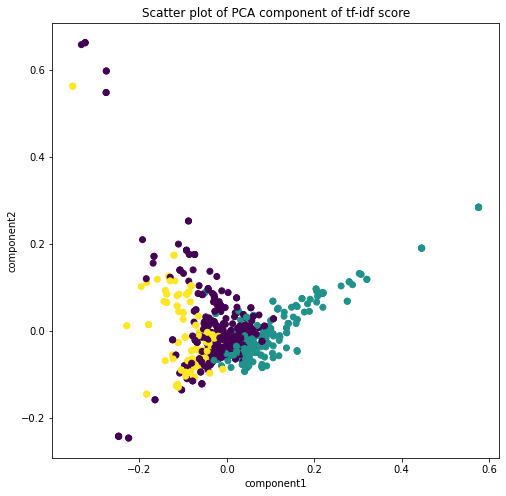

In [30]:
plt.figure(figsize = (8,8))
tfidf_dense = tfidf_train.todense()
coords = PCA(n_components=2).fit_transform(tfidf_dense)
plt.scatter(coords[:, 0], coords[:, 1], c=kmeans3.labels_)

plt.xlabel('component1')
plt.ylabel('component2')
plt.title("Scatter plot of PCA component of tf-idf score")
plt.show()

In [31]:
#10 tokens with the highest tfidf score in each cluster
df0=get_top_features(tfidf_train[kmeans3.labels_==0],features,10)
df1=get_top_features(tfidf_train[kmeans3.labels_==1],features,10)
df2=get_top_features(tfidf_train[kmeans3.labels_==2],features,10)
df = pd.concat([df0,df1,df2], axis=1)
df.columns = ["features_cluster0","tfidf_score","features_cluster1",	"tfidf_score","features_cluster2","tfidf_score"]
df

,features_cluster0,tfidf_score,features_cluster1,tfidf_score,features_cluster2,tfidf_score
0,thanks,8.978729,lucy,7.829494,john,7.266305
1,west,7.583455,email,7.411732,hunter,7.125049
2,desk,7.287744,file,6.854923,mike,7.053644
3,help,7.177243,call,6.014509,keith,6.613394
4,socal,6.687067,george,5.924686,shively,5.990388
5,trading,6.521099,project,5.903974,grigsby,5.868613
6,jeff,6.506498,fax,5.832506,holst,5.180318
7,meeting,5.981357,let,5.763968,meeting,4.765301
8,california,5.665429,know,5.699496,steve,4.476059
9,pdx,5.611456,rent,5.610297,frank,4.387284


In [33]:
label = kmeans3.labels_
print("sample from cluster 0")
for i in X_train[label ==0].sample(3):
  print(i)

print("\n sample from cluster 1")
for i in X_train[label ==1].sample(3):
  print(i)

print("\n sample from cluster 2")
for i in X_train[label ==2].sample(3):
  print(i)

sample from cluster 0
The topic will the the western natural gas market I may have overhead slides I will bring handouts
address http ectpdx sunoneectenroncom ctatham navsetup indexhtm id pallen password westgasx
http ectpdx sunoneectenroncom theizen wsccnav 

 sample from cluster 1
Jacques Still trying to close the loop on the of extensions Assuming that it is worked out today or tomorrow I would like to get whatever documents need to be completed to convey the partnership done I need to work with the engineer and architect to get things moving I am planning on writing a personal check to the engineer while I am setting up new accounts Let me know if there is a reason I should not do this Thanks for all your help so far Between your connections and expertise in structuring the loan you saved us from getting into a bad deal Phillip
Lucy Please open this excel file and input the rents and names due for this week Then email the file back 
Reagan I am still reviewing the numbers but here 

I sample three emails from each cluster. Two samples from cluster 0 contains hyperlink and two samples from cluster 2 are direct forwarding emails. It's still hard to distinguish topics among different clusters, this might because we don't have enough training sample or furthur email text cleaning is needed.

Now we try to predict the cluster of test datset set and visualize the clusters after applying PCA.

In [40]:
tfidf_predict = kmeans3.predict(tfidf_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


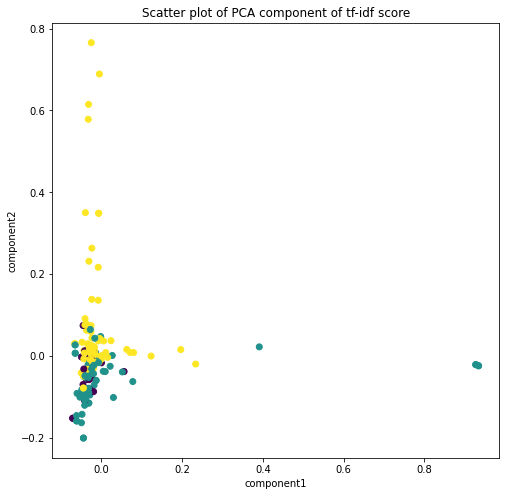

In [41]:
plt.figure(figsize = (8,8))
tfidf_dense = tfidf_test.todense()
coords = PCA(n_components=2).fit_transform(tfidf_dense)
plt.scatter(coords[:, 0], coords[:, 1], c=tfidf_predict)

plt.xlabel('component1')
plt.ylabel('component2')
plt.title("Scatter plot of PCA component of tf-idf score")
plt.show()

Clearly, we cannot observe a clear distribution on the predicted clusters. This might because tfidf score might not be a good representation of the dataset or the dataset itself is not large and informative enough for a clear classfication.

### K-means with word embedding using word2vec

Now I try to use word embedding for text representation. I use word2vec algorithm to train the word embeddings based on the give corpus(emails), and I also choose the dimension of the word embedding to be 100 and the context window size to be 3 given the limited dataset.

In [42]:
def train_word2vec(text,window_size,dim=100,epochs=20):
    """
    This function train the word2vec embedding and save into a bin file
    """
    #remove punctuation
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_list = [] 
    for sentence in text:
        token = tokenizer.tokenize(sentence.lower())
        word_list.append(token)
    #use the Word2Vec model to train embeddings
    model = Word2Vec(word_list, min_count=1,size= dim,workers=3, window =window_size)

    return model


In [43]:
word2vec_model = train_word2vec(enron['content'],3,100,epochs=15)
word2vec_model.save("word2vec.model")

In [44]:
model = Word2Vec.load("word2vec.model")

In [45]:
def get_tokens(df):
  df = df.reset_index(drop = True)
  tokens = []
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  
  for i in range(len(df)):

    token = tokenizer.tokenize(df[i].lower())

    if len(token)!=0:
      tokens.append(token)
    
  return tokens

In [46]:
X_train, X_test = train_test_split(enron['content'],test_size=0.2, random_state=42)
train_tokens = get_tokens(X_train)
test_tokens = get_tokens(X_test)

Since each email has different length. To get a embedding representation for the email, I first get word ebemdding for each token and take the average.

In [47]:
def get_sentence_embedding(model,data,dim = 100):
  emb_mean = np.zeros((len(data),dim))

  for i in range(len(data)):
    tokens = data[i]

    emb = np.zeros((len(tokens),dim))

    for j in range(len(tokens)):
      word = tokens[j]

      try:
        emb[j] = model.wv[word]
      except KeyError:

        emb = np.delete(emb,-1,0)

      emb[j] = model.wv[word]
    emb_mean[i] = np.mean(emb,axis = 0)
  
  return emb_mean

In [48]:
X_train_embmean = get_sentence_embedding(model,train_tokens)
X_test_embmean = get_sentence_embedding(model,test_tokens)

In [49]:
kmeans_w2v = KMeans(n_clusters=3,init='k-means++').fit(X_train_embmean)

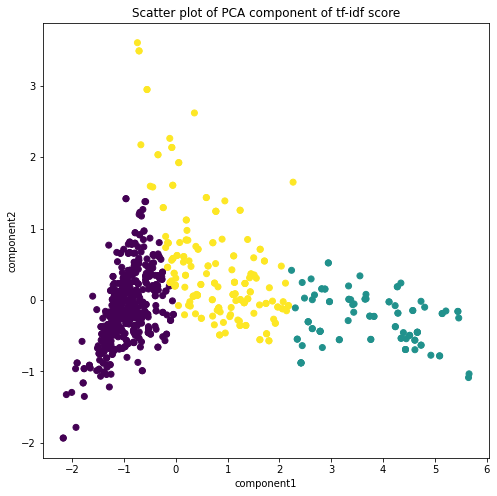

In [51]:
plt.figure(figsize = (8,8))
coords = PCA(n_components=2).fit_transform(X_train_embmean)
plt.scatter(coords[:, 0], coords[:, 1], c=kmeans_w2v.labels_)

plt.xlabel('component1')
plt.ylabel('component2')
plt.title("Scatter plot of PCA component of tf-idf score")
plt.show()

Here, I apply the same cluster model to embedding data. As we can observe from the graph, the clusters now are more easy to distinguish than using tfidf score. 





In [67]:
#sample from each cluster
label = kmeans_w2v.labels_
print("sample from cluster 0")
for i in X_train[X_train !=" "][label ==0].sample(3):
  print(i)

print("\n sample from cluster 1")
for i in X_train[X_train !=" "][label ==1].sample(3):
  print(i)

print("\n sample from cluster 2")
for i in X_train[X_train !=" "][label ==2].sample(3):
  print(i)

sample from cluster 0
George Below is a list of questions that Keith and I had regarding the Westgate project Ownership Structure What will be the ownership structure Limited partnership General partner What are all the legal entities that will be involved and in what capacityregarding ownership and liabilities Who owns the land improvements Who holds the various loans Is the land collateral Investment What happens to initial investment Is it used to purchase land for cashSecure future loans Why is the land cost spread out on the cash flow statement When is the actually needed Now or for the land closing Investment schedule Investment Return Is Equity Repayment the return of the original investment Is the plan to wait until the last unit is sold and closed before profits are distributed Debt Which entity is the borrower for each loan and what recourse or collateral is associated with each loan Improvement Construction Are these the only two loans Looks like it from the cash flow statem

We also sample three emails from each cluster here. From the sample result, it seems to be more likely for us to classify the characteristics of each cluster now while using word embedding. Samples from cluster 0 are emails attached with information and request. Samples from cluster 1 are all direct forwarding email without leaving a message. Two samples from cluster 2 are forwarding emails with leaving message. This is a simple example of (pre)clustering email by its content. If we have more data, we can then train better word embeddings and better unsupervised models, and in this way we are able to use the generated topics for each set of emails for further email classification problems. 

In [68]:
w2v_predict = kmeans_w2v.predict(X_test_embmean)

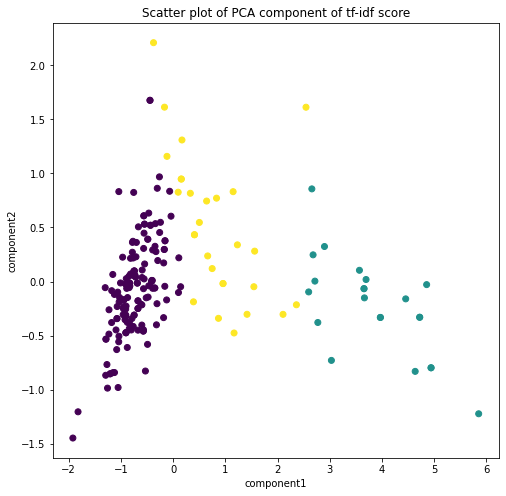

In [53]:
plt.figure(figsize = (8,8))
coords = PCA(n_components=2).fit_transform(X_test_embmean)
plt.scatter(coords[:, 0], coords[:, 1], c=w2v_predict)

plt.xlabel('component1')
plt.ylabel('component2')
plt.title("Scatter plot of PCA component of tf-idf score")
plt.show()

Same for the predicted cluster while using word2vec embedding. The visualization of cluster after applying PCA is more distinguishable than using tfidf score as email representation. This might because the dense representation of word embedding take context and the whole corpus into account and hence can better find the similarites and differences among emails.

### Other Use Cases

Other use cases might include predict the senders and their information, which can be used to detect spam emails and abnormal information. However, I didn't include this here since most emails in this truncated data set were sent by the same address, which would make the dataset highly imbalanced for classfication problem. 

Another use case might be name entity recognition. This might help detect special/abnormal people, events, or transactions in the email content. To achieve this, we may need a larger dataset and utilize other pre-trained word embeddings such as GloVe or more advanced word embedding technique such BERT to obtain better text representation. 